# Extract features

This notebook demonstrates how to compute features about the cellular micro-environment and add them to the anndata object. 

The inputs of this analysis are:
1. full checkpoint file (with both the model and datamodule). 
2. anndata object describing the tissue for which you want to extract the features

The output is the same anndata object with some extra annotations (stored in anndata.obsm)

We compute two types of features. 

1. The neighborhood composition vector (ncv) of each cell describes the proportion of cell_types in a local negihborhood. It can be computed by specifying the number of neighbours or the radius of the neighboorhood.
2. The semantic features learned by a self supervised model.

To compute the semantic features we follow this procedure:
- the anndata is converted into a sparse image
- the sparse image is cropped in overlapping patches which are fed into the trained model to extract patch-level features
- the patch-level features are transferred to the underlying cells
- the anndata object is exported with the additional features stored in anndata.obsm

This notebook is for demonstration only. 

To reproduce the results in the paper run the scripts in the "run" folder. 

See documentation for more details.

In [1]:
# TO REMOVE when notebook is stable

%load_ext autoreload
%autoreload 2

### Common Imports

In [2]:
import numpy
import torch
import seaborn
import tarfile
import os
import matplotlib
import matplotlib.pyplot as plt
from anndata import read_h5ad

# tissue_purifier import
import tissue_purifier as tp

### Download and untar the example dataset

In [3]:
import tissue_purifier.io

bucket_name = "ld-data-bucket"
data_source_path = "tissue-purifier/slideseq_testis_anndata_h5ad.tar.gz"
data_destination_path = "./slideseq_testis_anndata_h5ad.tar.gz"
data_destination_folder = "./testis_anndata"

# download and untar the data from google bucket
# tp.io.download_from_bucket(bucket_name, data_source_path, data_destination_path)

# untar the data
# with tarfile.open(data_destination_path, "r:gz") as fp:
#    fp.extractall(path=data_destination_folder)

# Make a list of all the h5ad files in the data_destination_folder
fname_list = []
for f in os.listdir(data_destination_folder):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

['anndata_sick3.h5ad', 'anndata_sick1.h5ad', 'anndata_sick2.h5ad', 'anndata_wt2.h5ad', 'anndata_wt1.h5ad', 'anndata_wt3.h5ad']


### Download the checkpoint file 
Altenatively you can use the checkpoint file generated by running notebook1.

In [7]:
bucket_name = "ld-data-bucket"
ckpt_source_path = "tissue-purifier/ckpt_barlow.pt"
ckpt_destination_path = "./ckpt_barlow.pt"

#tp.io.download_from_bucket(bucket_name, ckpt_source_path, ckpt_destination_path)

### Read in all anndata files

In [5]:
anndata_list = []
for fname in fname_list:
    anndata = read_h5ad(os.path.join(data_destination_folder, fname))
    print("Loaded {}".format(fname))
    anndata_list.append(anndata)

Loaded anndata_sick3.h5ad
Loaded anndata_sick1.h5ad
Loaded anndata_sick2.h5ad
Loaded anndata_wt2.h5ad
Loaded anndata_wt1.h5ad
Loaded anndata_wt3.h5ad


### Recreate the model and datamodule used for training. 

Here we use the Barlow but the same apporach works for Dino, Vae, Simclr

In [8]:
from tissue_purifier.data import AnndataFolderDM
from tissue_purifier.models.ssl_models import *
# now you have access to Barlow, SImclr, Dino, Vae


model = tp.models.ssl_models.Barlow.load_from_checkpoint(checkpoint_path=ckpt_destination_path, strict=False)
dm = tp.data.AnndataFolderDM(**model._hparams) 

### Convert the anndata to sparse images

Note that we use the 'anndata_to_sparseimage' method defined in the datamodule. \
We therefore know that we are making the sparse_images using the exact same recipe which was used during training. 

In [9]:
sp_imgs = [dm.anndata_to_sparseimage(anndata) for anndata in anndata_list]

number of elements ---> 33441
mean and median spacing 15.479421424523398, 15.47439133436206
The dense shape of the image is -> torch.Size([9, 1164, 1165])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 33433     4]
Occupacy (zero, single, double, ...) of voxels  in 2D sparse array (summed over category) -> [    0 33423     9]
number of elements ---> 27194
mean and median spacing 16.12433160571037, 15.591954248205585
The dense shape of the image is -> torch.Size([9, 1176, 1180])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 27190     2]
Occupacy (zero, single, double, ...) of voxels  in 2D sparse array (summed over category) -> [    0 27174    10]
number of elements ---> 42776
mean and median spacing 15.424869146306138, 15.42998109176031
The dense shape of the image is -> torch.Size([9, 1180, 1180])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 42772     2]
Occupacy (zero, single, double, ...) of vo

### Visualize one sparse_image as a sanity check

torch.Size([3, 1164, 1165])


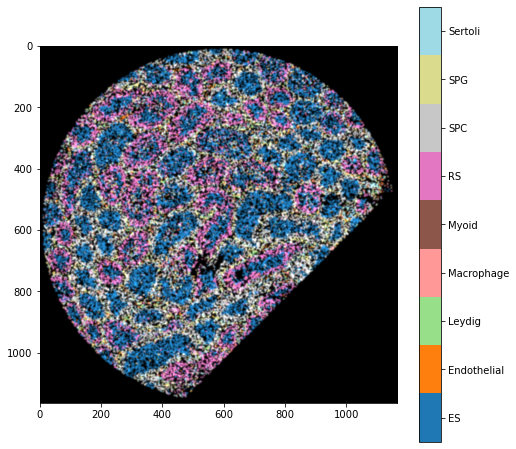

In [12]:
x, fig = sp_imgs[0].to_rgb(contrast=1.5)
print(x.shape)
fig

### Inspect the content of one sparse_image

Note that initially only the spot dictionary is non-empty

In [13]:
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (33441,)
 y_key <class 'numpy.ndarray'> (33441,)
 cat_key <class 'numpy.ndarray'> (33441,)

-- patch_properties_dict --

-- image_properties_dict --


### Compute the neighborhood composition vectors (ncv) at a given resolution 

Here we compute the features based on the k nearest neighbours. \
The same could be done by providing a radius so that only the neighbours within that radius are used.

In [14]:
for k in (25, 50, 100, 200, 500, 1000):
    sp_imgs[0].compute_ncv(feature_name="ncv_k{}".format(k), k=k)
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (33441,)
 y_key <class 'numpy.ndarray'> (33441,)
 cat_key <class 'numpy.ndarray'> (33441,)
 ncv_k25 <class 'numpy.ndarray'> (33441, 9)
 ncv_k50 <class 'numpy.ndarray'> (33441, 9)
 ncv_k100 <class 'numpy.ndarray'> (33441, 9)
 ncv_k200 <class 'numpy.ndarray'> (33441, 9)
 ncv_k500 <class 'numpy.ndarray'> (33441, 9)
 ncv_k1000 <class 'numpy.ndarray'> (33441, 9)

-- patch_properties_dict --

-- image_properties_dict --


### Compute the Barlow self-supervised features by "tiling" 
( i.e. split the image in overlapping patches and feeding each patch to the model to extract patch-level features)

In [15]:
# Restars the analysis from scratch if necessary
# sp_imgs[0].clear(patch_dict=True, image_dict=True)
# sp_imgs[0].trim_spot_dictionary(keys="barlow")
# sp_imgs[0].inspect()

In [17]:
n_patches_max = 1000 # cover the tissue with this many overlapping patches

# put sparse images and model on GPU if available
if torch.cuda.is_available():
    sp_imgs = [tmp.cuda() for tmp in sp_imgs]
    model = model.cuda()

sp_imgs[0].compute_patch_features(
    feature_name="barlow", 
    datamodule=dm, 
    model=model, 
    batch_size=64,
    n_patches_max=n_patches_max,
    overwrite=True)

# Note that the patch properties dictionary is not empty
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (33441,)
 y_key <class 'numpy.ndarray'> (33441,)
 cat_key <class 'numpy.ndarray'> (33441,)
 ncv_k25 <class 'numpy.ndarray'> (33441, 9)
 ncv_k50 <class 'numpy.ndarray'> (33441, 9)
 ncv_k100 <class 'numpy.ndarray'> (33441, 9)
 ncv_k200 <class 'numpy.ndarray'> (33441, 9)
 ncv_k500 <class 'numpy.ndarray'> (33441, 9)
 ncv_k1000 <class 'numpy.ndarray'> (33441, 9)

-- patch_properties_dict --
 barlow <class 'numpy.ndarray'> (1000, 512)
 barlow_patch_xywh <class 'numpy.ndarray'> (1000, 4)

-- image_properties_dict --


### Transfer annotations

Now we transfer the annotation from the patch to the spot level. \
Internally the annotation are first transferred patch -> image  and then image -> spot.

In [18]:
sp_imgs[0].transfer_patch_to_spot(keys_to_transfer=["barlow"], overwrite=True)

# Note that now the the patch properties dictionary is not empty
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (33441,)
 y_key <class 'numpy.ndarray'> (33441,)
 cat_key <class 'numpy.ndarray'> (33441,)
 ncv_k25 <class 'numpy.ndarray'> (33441, 9)
 ncv_k50 <class 'numpy.ndarray'> (33441, 9)
 ncv_k100 <class 'numpy.ndarray'> (33441, 9)
 ncv_k200 <class 'numpy.ndarray'> (33441, 9)
 ncv_k500 <class 'numpy.ndarray'> (33441, 9)
 ncv_k1000 <class 'numpy.ndarray'> (33441, 9)
 barlow <class 'numpy.ndarray'> (33441, 512)

-- patch_properties_dict --
 barlow <class 'numpy.ndarray'> (1000, 512)
 barlow_patch_xywh <class 'numpy.ndarray'> (1000, 4)

-- image_properties_dict --
 barlow <class 'numpy.ndarray'> (512, 1164, 1165)


### Visualization as a sanity check

We could visualize one of the channels of the image-level properties. For example:

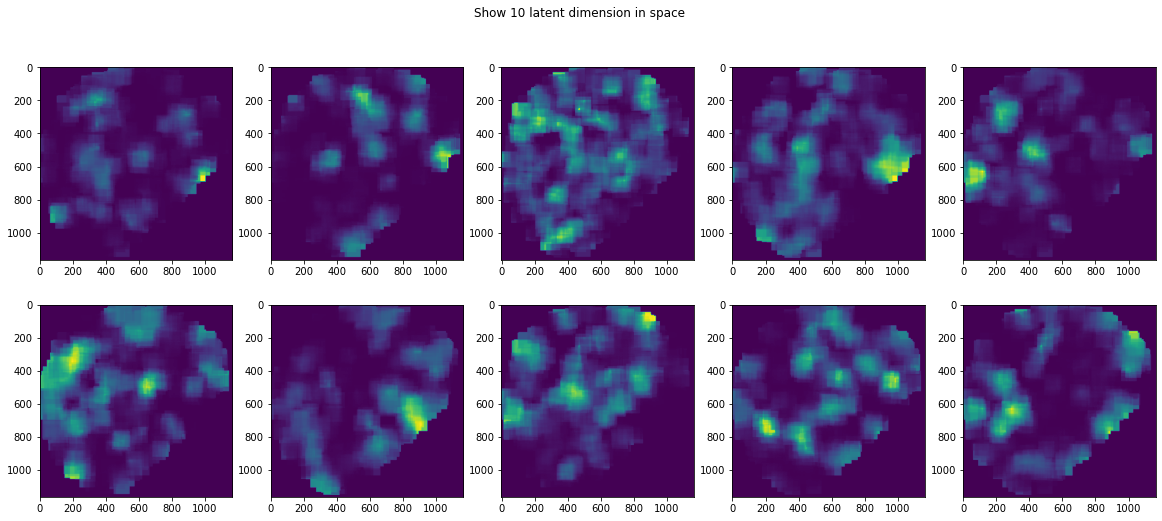

In [53]:
from tissue_purifier.plots import show_raw_one_channel
show_raw_one_channel(sp_imgs[0].read_from_image_dictionary(key="barlow")[:10], 
                    n_col=5,  
                    sup_title="Show 10 latent dimension in space",
                    cmap='viridis')

However this is not very imformative. \
A better idea is to:
- first compute few PCAs of the patch-features
- convert them into a percentile, i.e in the range (0, 1)
- transfer those to the image-level for visualization

In [25]:
from tissue_purifier.utils.validation_util import SmartPca, get_percentile

compute the first few pca of the Barlow features

torch.Size([1000, 512]) (1000, 10)


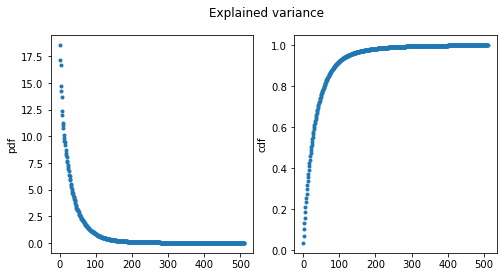

In [47]:
from tissue_purifier.plots import plot_cdf_pdf

pca = SmartPca(preprocess_strategy='z_score')

barlow_values, barlow_xywh = sp_imgs[0].read_from_patch_dictionary(key="barlow")
barlow_pca = pca.fit_transform(barlow_values, n_components=10)
print(barlow_values.shape, barlow_pca.shape)

plot_cdf_pdf(pdf_y=pca.explained_variance_.cpu().numpy(), sup_title="Explained variance")

compute the percentile

In [48]:
barlow_pca_percentile = get_percentile(barlow_pca, dim=0)

# Note that now every component has been scaled in (0.0, 1.0) 
print(numpy.min(barlow_pca_percentile, axis=0))
print(numpy.max(barlow_pca_percentile, axis=0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [49]:
# write to patch_dictionary
sp_imgs[0].write_to_patch_dictionary(key="barlow_percentile", values=barlow_pca_percentile, patches_xywh=barlow_xywh)

In [50]:
# transfer to image
sp_imgs[0].transfer_patch_to_spot(keys_to_transfer=["barlow_percentile"], overwrite=True)

# Note that now the the patch properties dictionary is not empty
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (33441,)
 y_key <class 'numpy.ndarray'> (33441,)
 cat_key <class 'numpy.ndarray'> (33441,)
 ncv_k25 <class 'numpy.ndarray'> (33441, 9)
 ncv_k50 <class 'numpy.ndarray'> (33441, 9)
 ncv_k100 <class 'numpy.ndarray'> (33441, 9)
 ncv_k200 <class 'numpy.ndarray'> (33441, 9)
 ncv_k500 <class 'numpy.ndarray'> (33441, 9)
 ncv_k1000 <class 'numpy.ndarray'> (33441, 9)
 barlow <class 'numpy.ndarray'> (33441, 512)
 barlow_percentile <class 'numpy.ndarray'> (33441, 10)

-- patch_properties_dict --
 barlow <class 'numpy.ndarray'> (1000, 512)
 barlow_patch_xywh <class 'numpy.ndarray'> (1000, 4)
 barlow_percentile <class 'numpy.ndarray'> (1000, 10)
 barlow_percentile_patch_xywh <class 'numpy.ndarray'> (1000, 4)

-- image_properties_dict --
 barlow <class 'numpy.ndarray'> (512, 1164, 1165)
 barlow_percentile <class 'numpy.ndarray'> (10, 1164, 1165)


Now we can visualize the PCA in space

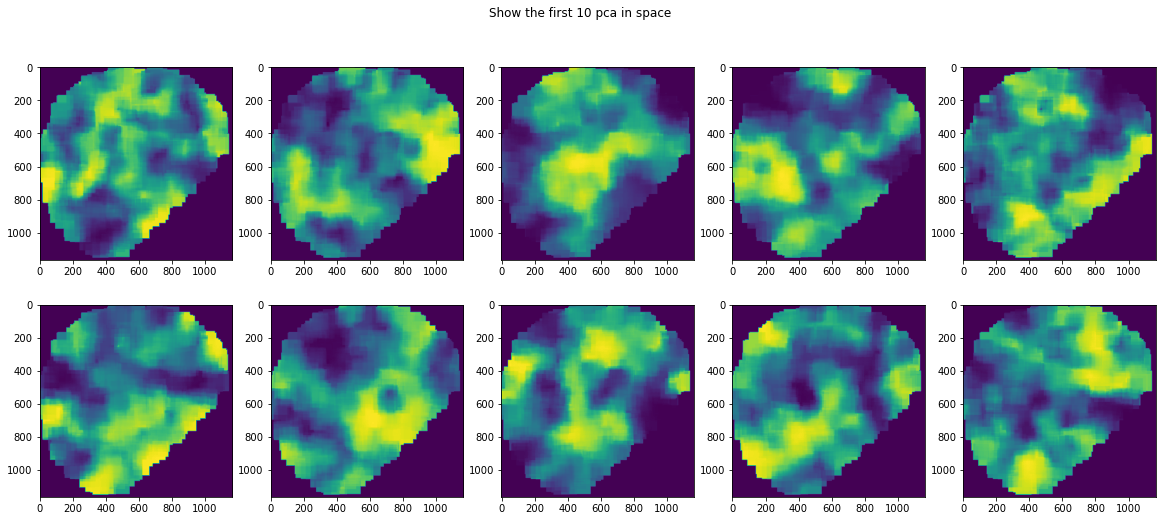

In [51]:
show_raw_one_channel(sp_imgs[0].read_from_image_dictionary(key="barlow_percentile")[:10], 
                    n_col=5,  
                    sup_title="Show the first 10 pca in space",
                    cmap='viridis')

# TODO

Look at older notebook. tp_02_validation for a lot of visualization.
Here we need pca percentile plot in space....

### Export the anndata and write it to file

In [52]:
adata = sp_imgs[0].to_anndata()
adata.write(filename="anndata_with_annotations.h5ad")
adata              

AnnData object with n_obs × n_vars = 33441 × 23514
    obs: 'x', 'y', 'cell_type'
    obsm: 'ncv_k25', 'ncv_k50', 'ncv_k100', 'ncv_k200', 'ncv_k500', 'ncv_k1000', 'barlow', 'barlow_percentile'